## Evaluation of model fit

*M. Jemeljanova, R.A. Collenteur (November 2022)*

This notebook is part of the manuscript by Jemeljanova et al. titled "*Modeling hydraulic heads with impulse response functions in different environmental settings*" submitted to Journal of Hydrology: Regional Studies.

## 0. Import python packages

In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
import pastas as ps
os.chdir('../') 

ps.set_log_level("ERROR")
ps.show_versions()

structures = ['LG', 'L4','NLG', 'NLS']

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Python version: 3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 08:55:37) 
[Clang 14.0.6 ]
Numpy version: 1.23.5
Scipy version: 1.9.3
Pandas version: 1.5.2
Pastas version: 0.21.0
Matplotlib version: 3.6.2


## 1. Load metrics

In [2]:
metrics = pd.read_csv(os.path.join(os.getcwd(), 'output', 'metrics.csv'), index_col=[0, 1])
metrics = metrics.loc[:, ["RMSE_c", "NSE_c", "KGE_c", "RMSE_v", "NSE_v", "KGE_v"]]
metrics.head()

RMSE_c     NSE_c     KGE_c    RMSE_v     NSE_v     KGE_v
LV|9665 LG   0.485406  0.291526  0.358307  0.452322  0.466269  0.468474
        L4   0.382597  0.559853  0.698245  0.600052  0.060701  0.606993
        NLG  0.372915  0.581849  0.633120  0.432140  0.512836  0.706489
        NLS  0.393897  0.533471  0.483766  0.427166  0.523986  0.640590
LV|9667 LG   0.181684  0.722228  0.747378  0.219426  0.644504  0.761891

### Compute some summmary statistics for the paper

In [3]:
metrics.groupby(metrics.index.get_level_values(1)).describe().T

L4          LG         NLG         NLS
RMSE_c count  460.000000  460.000000  460.000000  460.000000
       mean     0.289583    0.297536    0.296893    0.271852
       std      0.235996    0.260247    0.254522    0.206020
       min      0.021690    0.021655    0.017930    0.020939
       25%      0.152021    0.156894    0.155448    0.146151
       50%      0.215769    0.222000    0.217465    0.211729
       75%      0.352694    0.355618    0.357145    0.342130
       max      1.921496    3.112385    2.774652    1.559229
NSE_c  count  460.000000  460.000000  460.000000  460.000000
       mean     0.453134    0.424935    0.428759    0.494354
       std      0.213578    0.241747    0.223921    0.219031
       min     -0.579937   -1.958938   -1.351614   -0.595341
       25%      0.328512    0.288461    0.301336    0.390567
       50%      0.484523    0.459255    0.449679    0.520291
       75%      0.598248    0.588913    0.581909    0.646908
       max      0.844466    0.844466    0.907594    0.900763
KGE_c  count  460.000000  460.000000  460.000000  460.000000
       mean     0.551543    0.533387    0.503161    0.539527
       std      0.231325    0.238277    0.227355    0.224888
       min     -0.349634   -0.369312   -0.482083   -0.472442
       25%      0.459380    0.418313    0.378151    0.430557
       50%      0.607645    0.585734    0.546200    0.565805
       75%      0.705202    0.708463    0.661807    0.701636
       max      0.914979    0.912045    0.924838    0.927022
RMSE_v count  460.000000  460.000000  460.000000  460.000000
       mean     0.388650    0.393320    0.401037    0.385818
       std      0.465594    0.430470    0.438886    0.438277
       min      0.059085    0.058281    0.060536    0.055569
       25%      0.183874    0.188005    0.191932    0.180731
       50%      0.274996    0.276703    0.279893    0.270654
       75%      0.420503    0.433298    0.445120    0.413301
       max      5.066685    4.775921    4.781029    4.754469
NSE_v  count  460.000000  460.000000  460.000000  460.000000
       mean    -0.483730   -1.742425   -1.051581   -0.446007
       std      3.628472   26.684344   13.108438    4.910980
       min    -47.547385 -568.308111 -262.559762  -98.782987
       25%     -0.314969   -0.283285   -0.291586   -0.277737
       50%      0.273264    0.237742    0.191201    0.239528
       75%      0.494047    0.466424    0.421371    0.493985
       max      0.872308    0.891250    0.807936    0.851520
KGE_v  count  460.000000  460.000000  460.000000  460.000000
       mean     0.457828    0.416349    0.350622    0.414622
       std      0.394394    0.651859    0.786428    0.406496
       min     -2.636801  -10.284733  -14.468453   -3.211043
       25%      0.335290    0.328462    0.248841    0.275512
       50%      0.571264    0.535385    0.458752    0.491403
       75%      0.698019    0.681600    0.609410    0.644296
       max      0.914520    0.918191    0.890138    0.915208

## 2. Count models passing thresholds

In [4]:
threshold = 0.65

passed = metrics.loc[(metrics.loc[:, "NSE_c"] > threshold) &
                     (metrics.loc[:, "KGE_c"] > threshold)].index
passed = pd.DataFrame(index=passed, columns=["value"], data=1)
passed_cal = passed.unstack().fillna(0)

print("Number of locations with at least 1 model passed thresholds in calibration period:", 
      passed_cal.index.size)

Number of locations with at least 1 model passed thresholds in calibration period: 141


In [5]:
passed = metrics.loc[(metrics.loc[:, "NSE_v"] > threshold) &
                     (metrics.loc[:, "KGE_v"] > threshold)].index
passed = pd.DataFrame(index=passed, columns=["value"], data=1)
passed_val = passed.unstack().fillna(0)

print("Number of locations with at least 1 model passed thresholds in validation period:", 
      passed_val.index.size)

Number of locations with at least 1 model passed thresholds in validation period: 59


In [6]:
table = pd.concat([passed_cal.sum(), passed_val.sum()], axis=1)
table.columns = ["Calibration", "Validation"]
table.loc["Sum", :] = table.sum(axis=0).values
table.astype(int)

Calibration  Validation
value L4            76          22
      LG            73          27
      NLG           66          25
      NLS          108          36
Sum                323         110

## 3. What is threshold is 0.5?

In [7]:
threshold = 0.5

passed = metrics.loc[(metrics.loc[:, "NSE_c"] > threshold) &
                     (metrics.loc[:, "KGE_c"] > threshold)].index
passed = pd.DataFrame(index=passed, columns=["value"], data=1)
passed_cal = passed.unstack().fillna(0)

print("Number of locations with at least 1 model passed thresholds in calibration period:", 
      passed_cal.index.size)

passed = metrics.loc[(metrics.loc[:, "NSE_v"] > threshold) &
                     (metrics.loc[:, "KGE_v"] > threshold)].index
passed = pd.DataFrame(index=passed, columns=["value"], data=1)
passed_val = passed.unstack().fillna(0)

print("Number of locations with at least 1 model passed thresholds in validation period:", 
      passed_val.index.size)

table = pd.concat([passed_cal.sum(), passed_val.sum()], axis=1)
table.columns = ["Calibration", "Validation"]
table.loc["Sum", :] = table.sum(axis=0).values
table.astype(int)

Number of locations with at least 1 model passed thresholds in calibration period: 300
Number of locations with at least 1 model passed thresholds in validation period: 153


Calibration  Validation
value L4           216         107
      LG           193          93
      NLG          177          79
      NLS          232         101
Sum                818         380

## 4. Boxplots of model fits

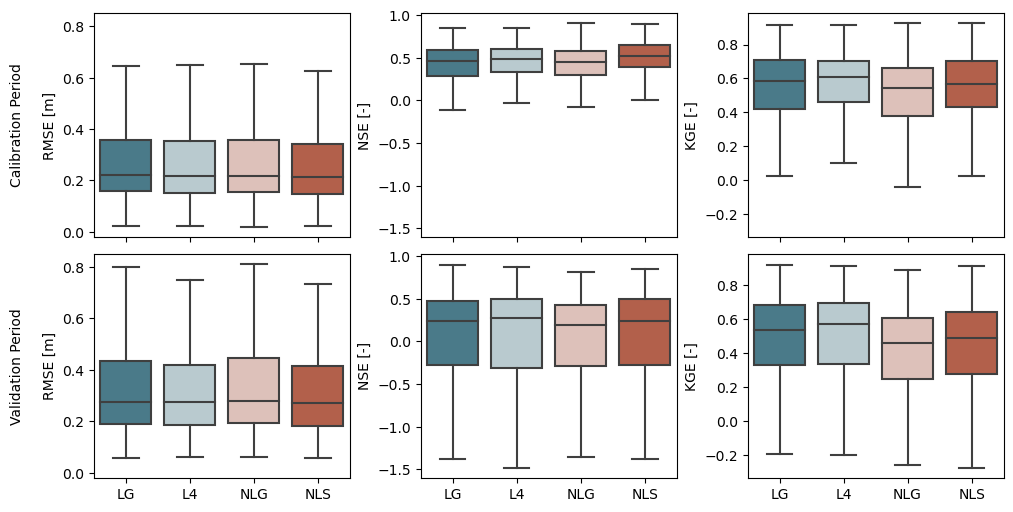

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(10,5), sharey="col", sharex="col", constrained_layout=True)
axes = axes.flatten()

for i, stat in enumerate(metrics.columns):
    sns.boxplot(metrics.loc[:, stat].unstack(), ax=axes[i], order=structures,
                showfliers = False, palette = sns.diverging_palette(220, 20, n=4))
    
for i, title in enumerate(["RMSE [m]", "NSE [-]", "KGE [-]"]):
    axes[int(i)].set_ylabel(title)
    axes[int(i+3)].set_ylabel(title)

axes[0].set_ylabel("Calibration Period\n\nRMSE [m]")
axes[3].set_ylabel("Validation Period\n\nRMSE [m]")

plt.savefig(os.path.join(os.getcwd(), 'output', 'paper_figures', 'figure_02.pdf'),
            bbox_inches="tight", dpi=300)

## 5. Example for paper how snow is important

In [9]:
well = "EE2010"
mls = {}
for structure in ['LG', 'L4','NLG', 'NLS']: # the order of plotting
    mls[structure] = ps.io.load(os.path.join(os.getcwd(), 'output', 'models', well + "_" + structure + '.pas'))

/opt/anaconda3/envs/stable_pastas/lib/python3.9/site-packages/pastas/io/base.py:137: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for param, value in ml.parameters.loc[:, "initial"].iteritems():
/opt/anaconda3/envs/stable_pastas/lib/python3.9/site-packages/pastas/io/base.py:137: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for param, value in ml.parameters.loc[:, "initial"].iteritems():
/opt/anaconda3/envs/stable_pastas/lib/python3.9/site-packages/pastas/io/base.py:137: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for param, value in ml.parameters.loc[:, "initial"].iteritems():
/opt/anaconda3/envs/stable_pastas/lib/python3.9/site-packages/pastas/io/base.py:137: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for param, value in ml.parameters.loc[:, "initial"].iteri

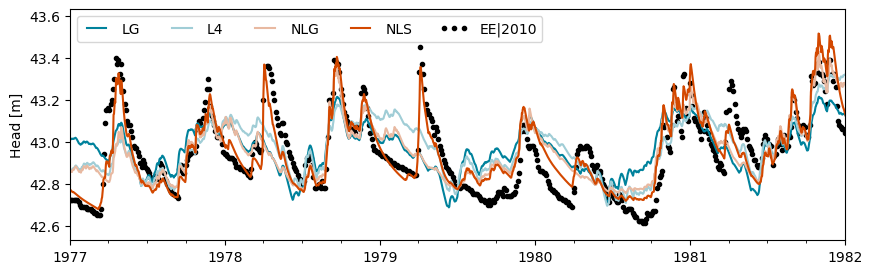

In [10]:
fig, ax = plt.subplots(1,1, figsize=(10,3))
palette = sns.diverging_palette(220, 20, n = 4, s = 100, l = 50)

for i, (name, ml) in enumerate(mls.items()):
    ml.simulate().plot(ax=ax, label=name, color=palette[i])
    
ml.observations().plot(marker=".", linestyle=" ", color="k", zorder=-10)

plt.xlim("1977", "1982")
plt.ylabel("Head [m]")
plt.legend(ncol=5, numpoints=3)

plt.savefig(os.path.join(os.getcwd(), 'output', 'paper_figures', 'figure_07.pdf'),
            bbox_inches="tight", dpi=300)